In [1]:
import os
import glob
import cv2
import numpy as np
import time
import torch
import torch.nn as nn

from matplotlib import pyplot as plt

from driver.driver import io_shape_dict
from driver.driver_base import FINNExampleOverlay
from utils import (clip_coords, scale_coords, letterbox, 
                   xywh2xyxy, non_max_suppression,  
                   visualize_boxes)
from models import Detect

In [2]:
driver = FINNExampleOverlay(
    bitfile_name="./bitfile/finn-accel.bit",
    platform="zynq-iodma",
    io_shape_dict=io_shape_dict,
    batch_size=1,
    runtime_weight_dir="runtime_weights/",
)

In [3]:
test_img_folder = "../../inputs/images/"
test_img_paths = glob.glob(test_img_folder + "*.jpg")
output_path = "../../test_outputs/"
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [4]:
names = ['face']
nc  = 1
anchors = np.array([[10,14,23,27,37,58]]) / np.array([32])
scale = np.load("./bitfile/scale.npy")
detect_head = Detect(nc, anchors)

{'runtime[ms]': 143.4307098388672, 'throughput[images/s]': 6.972007606484129, 'DRAM_in_bandwidth[Mb/s]': 3.619643245043152, 'DRAM_out_bandwidth[Mb/s]': 0.06362654141677417, 'fclk[mhz]': 100.0, 'batch_size': 1, 'fold_input[ms]': 0.11658668518066406, 'pack_input[ms]': 0.1308917999267578, 'copy_input_data_to_device[ms]': 3.3235549926757812, 'copy_output_data_from_device[ms]': 0.2605915069580078, 'unpack_output[ms]': 574.5406150817871, 'unfold_output[ms]': 0.05841255187988281}
12 face


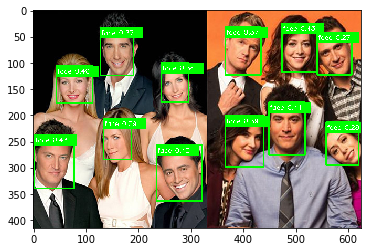

{'runtime[ms]': 143.44334602355957, 'throughput[images/s]': 6.971393429680293, 'DRAM_in_bandwidth[Mb/s]': 3.619324384100258, 'DRAM_out_bandwidth[Mb/s]': 0.06362093643926237, 'fclk[mhz]': 100.0, 'batch_size': 1, 'fold_input[ms]': 0.11968612670898438, 'pack_input[ms]': 0.133514404296875, 'copy_input_data_to_device[ms]': 3.370046615600586, 'copy_output_data_from_device[ms]': 0.2601146697998047, 'unpack_output[ms]': 578.6895751953125, 'unfold_output[ms]': 0.05435943603515625}
1 face


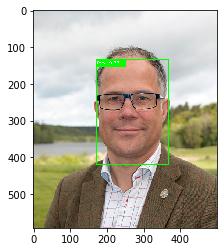

{'runtime[ms]': 143.42474937438965, 'throughput[images/s]': 6.972297350087355, 'DRAM_in_bandwidth[Mb/s]': 3.619793670650152, 'DRAM_out_bandwidth[Mb/s]': 0.0636291856168972, 'fclk[mhz]': 100.0, 'batch_size': 1, 'fold_input[ms]': 0.11944770812988281, 'pack_input[ms]': 0.1327991485595703, 'copy_input_data_to_device[ms]': 3.1919479370117188, 'copy_output_data_from_device[ms]': 0.2627372741699219, 'unpack_output[ms]': 573.0452537536621, 'unfold_output[ms]': 0.06341934204101562}
2 face


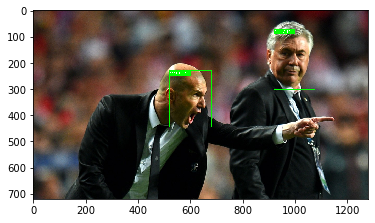

{'runtime[ms]': 143.4800624847412, 'throughput[images/s]': 6.969609454319466, 'DRAM_in_bandwidth[Mb/s]': 3.618398201180128, 'DRAM_out_bandwidth[Mb/s]': 0.06360465588011945, 'fclk[mhz]': 100.0, 'batch_size': 1, 'fold_input[ms]': 0.11968612670898438, 'pack_input[ms]': 0.13184547424316406, 'copy_input_data_to_device[ms]': 3.2901763916015625, 'copy_output_data_from_device[ms]': 0.2651214599609375, 'unpack_output[ms]': 578.4885883331299, 'unfold_output[ms]': 0.054836273193359375}
2 face


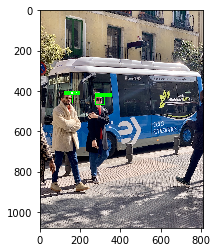

In [5]:
for number, test_img_path in enumerate(test_img_paths):
    img_org = cv2.imread(test_img_path)
    img = img_org.copy()
    
    h, w, _ = img_org.shape
    img, ratio, (dw, dh) = letterbox(img, (416,416), auto=False)
    
    #img = img.transpose((2, 0, 1))[::-1]  # HWC to CHW, BGR to RGB
    img = img[:, :, ::-1]
    img = np.ascontiguousarray(img)
    #print(img.shape)
    #plt.imshow(img)
    #plt.show()
    
    #img = (img-mean) #/255.0
    
    img = img.astype(np.uint8)
        
    #driver_in = img.reshape(driver.ishape_normal)
    driver_in = np.expand_dims(img, 0)
    #print("Input buffer shape is %s and datatype is %s" % (str(driver_in.shape), str(driver_in.dtype)))
    
    #print(driver_in)
    
    #t1 = time.time()
    output = driver.execute(driver_in)
    #print(output)
    #t2 = time.time()
    output = scale*output
    #print(output.shape)
    output = output.transpose(0,3,1,2)
    #print(f"Time passed for driver execution: {t2-t1} sec")
    #print(f"Output buffer shape is {output.shape} and datatype is {output.dtype}")
    #print(f"Output: {sigmoid(output[..., 5])}")
    #t3 = time.time()
    output = torch.from_numpy(output)
    pred = detect_head([output])[0]
    #output = sigmoid(output)[0]
    #t4 = time.time()
    #print(f"Time passed for sigmoid execution: {t4-t3} sec")
    #print(f"Output: {sigmoid(output[..., 16])}")
    #print(output[0,1,1,:])
    
    # Get detected boxes_detected, labels, confidences, class-scores.
    #t5 = time.time()
    pred = non_max_suppression(pred, conf_thres=0.20, iou_thres=0.10, classes=None, max_det=1000)
    #t6 = time.time()
    #print(f"Time passed for decode execution: {t6-t5} sec")
    
    boxes_detected, class_names_detected, probs_detected = [], [], []
    # Process predictions
    for i, det in enumerate(pred):  # per image
        if len(det):
            #print(det)
            # Rescale boxes from img_size to im0 size
            det[:, :4] = scale_coords(img.shape, det[:, :4], img_org.shape).round()
            #det[:, :4] = det[:, :4].round()
            # Print results
            for c in np.unique(det[:, -1]):
                n = (det[:, -1] == c).sum()  # detections per class
                print(f"{n} {names[int(c)]}")  # add to string


            # Write results
            for *xyxy, conf, cls in reversed(det):
                c = int(cls)  # integer class
                label = f'{names[c]} {conf:.2f}'
                boxes_detected.append(xyxy)
                class_names_detected.append(names[c])
                probs_detected.append(conf)
                
    #print(boxes_detected)

    # Visualize.
    image_boxes = visualize_boxes(img_org, boxes_detected, class_names_detected, probs_detected)
    cv2.imwrite(output_path+f"{number}.jpg", image_boxes)
    
    plt.imshow(cv2.cvtColor(image_boxes, cv2.COLOR_BGR2RGB))
    plt.show()
    
